In [22]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pickle
import time

import torch
torch.set_default_tensor_type(torch.DoubleTensor)

from spatial_scene_grammars.nodes import *
from spatial_scene_grammars.rules import *
from spatial_scene_grammars.scene_grammar import *
from spatial_scene_grammars.visualization import *

# DEPENDENCY
DEPENDENCY = 1
if DEPENDENCY:
    from spatial_scene_grammars_examples.singles_pairs.grammar_dependency import *
else:
    from spatial_scene_grammars_examples.singles_pairs.grammar_constituency import *
    
from spatial_scene_grammars.parsing import *
from spatial_scene_grammars.sampling import *

import meshcat
import meshcat.geometry as meshcat_geom

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
if 'vis' not in globals():
    vis = meshcat.Visualizer()
    
vis.delete()

def reset_bg():
    vis['/Background'].set_property("top_color", [0.2, 0.2, 0.2])
    vis['/Background'].set_property("bottom_color", [.32, .32, .35])

base_url = "http://127.0.0.1"
meshcat_url = base_url + ":" + vis.url().split(":")[-1]
print("Meshcat url: ", meshcat_url)
from IPython.display import HTML
HTML("""
    <div style="height: 400px; width: 100%; overflow-x: auto; overflow-y: hidden; resize: both">
    <iframe src="{url}" style="width: 100%; height: 100%; border: none"></iframe>
</div>
""".format(url=meshcat_url))

Meshcat url:  http://127.0.0.1:7000/static/


In [24]:
# Draw a random sample (or load one) from the grammar and visualize it.
grammar = SpatialSceneGrammar(
    root_node_type = Root,
    root_node_tf = torch.eye(4)
)

pyro.set_rng_seed(63)

REGENERATE = True
EXAMPLE_FILE = "single_scene.pickle"
if REGENERATE or not os.path.exists(EXAMPLE_FILE):
    with open(EXAMPLE_FILE, "wb") as f:
        tree = grammar.sample_tree(detach=True)
        observed_nodes = tree.get_observed_nodes()
        pickle.dump((tree, observed_nodes), f)

with open(EXAMPLE_FILE, "rb") as f:
    tree, observed_nodes = pickle.load(f)

print("Sampled scene with %d objects and %d pairs." % 
      (len(tree.find_nodes_by_type(Object)),
       len(tree.find_nodes_by_type(Pair))))
print("Sampled tree has score %f" % tree.score().item())
draw_scene_tree_contents_meshcat(tree, zmq_url=vis.window.zmq_url)
draw_scene_tree_structure_meshcat(tree, zmq_url=vis.window.zmq_url, alpha=0.5, node_sphere_size=0.05, with_triad=False)
reset_bg()

Sampled scene with 4 objects and 1 pairs.
Sampled tree has score -20.471196


Super tree has 15 nodes


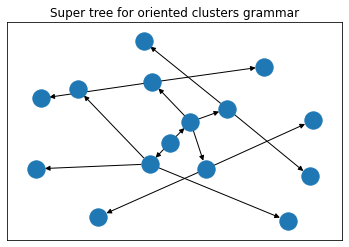

In [25]:
# Draw supertree for this grammar
super_tree = grammar.make_super_tree(max_recursion_depth=10)
nx.draw_networkx(super_tree, with_labels=False)
plt.title("Super tree for oriented clusters grammar")
print("Super tree has %d nodes" % len(list(super_tree.nodes)))

# Greedy parsing

In [26]:
vis["greedy_scene_tree"].delete()
pyro.set_rng_seed(42)
for k in range(1):
    parse_tree, score = sample_likely_tree_with_greedy_parsing(grammar, observed_nodes, verbose=True)
    print("FINAL SCORE: ", score)
    print(parse_tree.nodes)
    draw_scene_tree_structure_meshcat(parse_tree, zmq_url=vis.window.zmq_url, prefix="greedy_scene_tree/%d" % k, linewidth=20, with_triad=False, node_sphere_size=0.05, alpha=0.5)

ERROR:root:Exceeding iteration limit on greedy parsing attempt.


[<spatial_scene_grammars_examples.singles_pairs.grammar_dependency.Singles object at 0x7f064715ef28>, <spatial_scene_grammars_examples.singles_pairs.grammar_dependency.Pairs object at 0x7f064715e5c0>, <spatial_scene_grammars_examples.singles_pairs.grammar_dependency.Pair object at 0x7f064715e710>, <spatial_scene_grammars_examples.singles_pairs.grammar_dependency.Pair object at 0x7f064715e0b8>, <spatial_scene_grammars_examples.singles_pairs.grammar_dependency.Pair object at 0x7f064715ec18>]
5 top-down, 0 bottom-up candidates.
Connecting <spatial_scene_grammars_examples.singles_pairs.grammar_dependency.Singles object at 0x7f064715ef28> to <spatial_scene_grammars_examples.singles_pairs.grammar_dependency.Object object at 0x7f064715ecf8>
Connecting <spatial_scene_grammars_examples.singles_pairs.grammar_dependency.Singles object at 0x7f064715ef28> to <spatial_scene_grammars_examples.singles_pairs.grammar_dependency.Object object at 0x7f064715eef0>
Connecting <spatial_scene_grammars_examples

ERROR:root:Exceeding iteration limit on greedy parsing attempt.
ERROR:root:Exceeding iteration limit on greedy parsing attempt.
ERROR:root:Exceeding iteration limit on greedy parsing attempt.
ERROR:root:Exceeding iteration limit on greedy parsing attempt.
ERROR:root:Exceeding iteration limit on greedy parsing attempt.
ERROR:root:Exceeding iteration limit on greedy parsing attempt.
ERROR:root:Exceeding iteration limit on greedy parsing attempt.
ERROR:root:Exceeding iteration limit on greedy parsing attempt.
ERROR:root:Exceeding iteration limit on greedy parsing attempt.
ERROR:root:Failed to find feasible tree by greedy parsing.


Found tree with score -inf in 1.684201s
FINAL SCORE:  tensor(-inf)
[<spatial_scene_grammars_examples.singles_pairs.grammar_dependency.Root object at 0x7f064720a320>, <spatial_scene_grammars_examples.singles_pairs.grammar_dependency.Object object at 0x7f064715eef0>, <spatial_scene_grammars_examples.singles_pairs.grammar_dependency.Object object at 0x7f064715ecf8>, <spatial_scene_grammars_examples.singles_pairs.grammar_dependency.Object object at 0x7f064715edd8>, <spatial_scene_grammars_examples.singles_pairs.grammar_dependency.Object object at 0x7f064715e438>]


# MIP Parsing

In [20]:
# Get single-shot parse of scene
inference_results = infer_mle_tree_with_mip(
    grammar, observed_nodes, verbose=True, max_scene_extent_in_any_dir=10., N_solutions=10
)

Starting setup.
Activation vars allocated.
Equivalent sets:  13 13


Continuous variables and SO(3) constraints allocated for all equivalence sets.


Setup time:  0.7529275417327881
Num vars:  4894
Num constraints:  14063


KeyboardInterrupt: 

In [6]:
mip_optimized_trees = get_optimized_trees_from_mip_results(inference_results)
draw_scene_tree_structure_meshcat(mip_optimized_trees[0], zmq_url=vis.window.zmq_url, prefix="mip_scene_tree", linewidth=20, with_triad=False, node_sphere_size=0.05, alpha=0.5, )

for tree in mip_optimized_trees:
    print(tree.score())
for node in mip_optimized_trees[0]:
    err = torch.matmul(node.rotation.transpose(0, 1), node.rotation) - torch.eye(3)
    print("Avg elementwise deviation from R^T R = I: ", err.abs().mean())

tensor([-20.4712])
tensor([-21.0794])
tensor([-91.0093])
tensor([-91.8250])
tensor([-105.9915])
tensor([-107.4153])
tensor([-146.6255])
tensor([-147.2336])
tensor([-147.4082])
tensor([-148.0163])
Avg elementwise deviation from R^T R = I:  tensor(6.4763e-17)
Avg elementwise deviation from R^T R = I:  tensor(6.4763e-17)
Avg elementwise deviation from R^T R = I:  tensor(6.4763e-17)
Avg elementwise deviation from R^T R = I:  tensor(1.8504e-16)
Avg elementwise deviation from R^T R = I:  tensor(2.5905e-16)
Avg elementwise deviation from R^T R = I:  tensor(3.4916e-16)
Avg elementwise deviation from R^T R = I:  tensor(3.4916e-16)
Avg elementwise deviation from R^T R = I:  tensor(2.1588e-16)


In [7]:
# Do NLP refinement of top trees
vis["topNrefined"].delete()
refined_trees = []
for k, mip_optimized_tree in enumerate(mip_optimized_trees):
    refinement_results = optimize_scene_tree_with_nlp(grammar, mip_optimized_tree, verbose=False)
    refined_trees.append(refinement_results.refined_tree)
    draw_scene_tree_structure_meshcat(refined_trees[-1], zmq_url=vis.window.zmq_url, prefix="topNrefined/%d_%f" % (k, refined_trees[-1].score().item()), node_sphere_size=0.05, with_triad=False, alpha=0.5, linewidth=20)
    print(refined_trees[-1].score())
draw_scene_tree_structure_meshcat(refined_trees[0], zmq_url=vis.window.zmq_url, prefix="refined_scene_tree", node_sphere_size=0.05, with_triad=False, alpha=0.5, linewidth=20)

reset_bg()

tensor([-20.4751])
tensor([-21.0829])
tensor([-91.0101])
tensor([-91.8226])
tensor([-105.9924])
tensor([-107.4190])
tensor([-146.6245])
tensor([-147.2326])
tensor([-147.4106])
tensor([-148.0187])
